In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
import pygenstability as pgs

from matplotlib.pyplot import figure
from pygenstability import plotting
from scipy.linalg import block_diag

from mcf import MCF

In [9]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

# Construct ER network

/tmp/ipykernel_53298/1105762832.py:8: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



<Figure size 432x288 with 0 Axes>

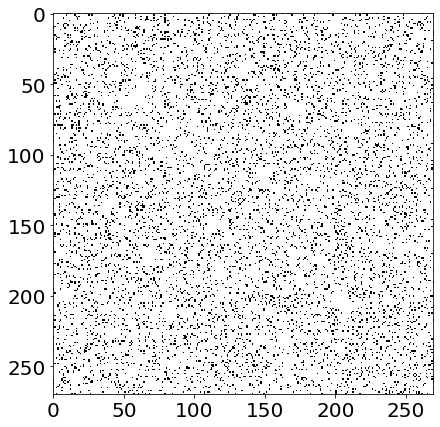

In [10]:
n = 270
m = 3473
seed = 2#20160 

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

A = nx.adjacency_matrix(G).toarray()

# plot matrix
plt.figure()
figure(figsize=(8, 7))
plt.imshow(A, interpolation="nearest",cmap='binary')
plt.savefig(root_fig +'ER_adjacency_matrix.pdf', bbox_inches='tight')
plt.show()

In [11]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

In [12]:
np.unique(A)

array([0, 1])

# Apply MS analysis


In [13]:
# Set MS parameters
n_scale = 200
min_scale = -1.5
max_scale = 0.5

In [14]:
# Run MS analysis
# MS_results = pgs.run(A,min_scale= min_scale,max_scale= max_scale,n_scale= n_scale,n_workers=4, constructor="continuous_normalized")

In [15]:
# Load data (deserialize)
with open("ER_MS_results.pkl", 'rb') as handle:
    MS_results = pickle.load(handle)

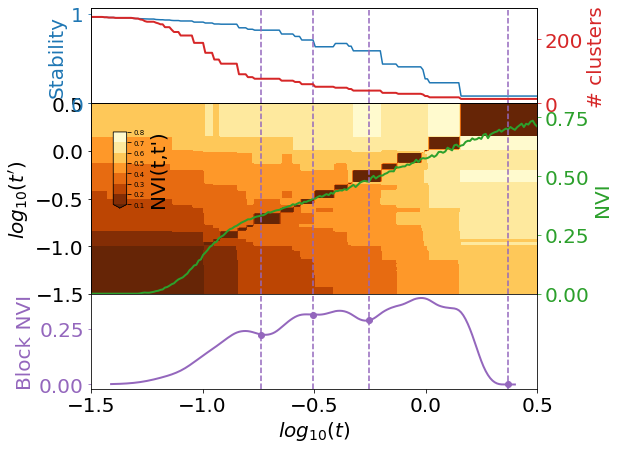

In [16]:
figure(figsize=(8, 7))
plotting.plot_scan(MS_results)
plt.show()

# Apply MCF

In [17]:
partitions = MS_results["community_id"]
log_scales = np.log10(MS_results['scales'])

In [18]:
n_partitions = len(partitions)
n_nodes = len(partitions[0])
partitions_matrix = np.zeros((n_nodes,n_partitions))

for i in range(0,n_partitions):
    partitions_matrix[:,i] = partitions[i]

partitions_matrix = np.asarray(partitions_matrix, dtype="int")

np.savetxt("ER_Partitions.csv", partitions_matrix.astype(int), fmt='%i', delimiter=',')

In [19]:
# initialise MCF object
mcf = MCF()
mcf.load_data(partitions,log_scales)

# build filtration and compute PH
mcf.build_filtration()
mcf.compute_persistence()

Constructing filtration with GUDHI ...


100%|██████████| 200/200 [00:00<00:00, 738.16it/s] 


Computing persistence with GUDHI ... 


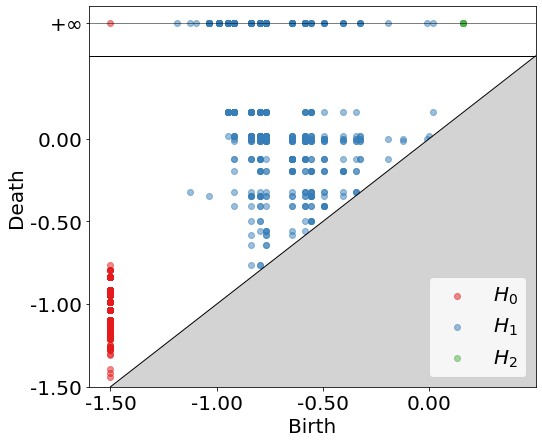

In [25]:
# Plot persistence diagram
ax = mcf.plot_persistence_diagram()
plt.savefig(root_fig +'ER_PD.pdf', dpi=fig.dpi,bbox_inches='tight')

In [21]:
from msfiltration.measures import compute_persistent_hierarchy, compute_persistent_conflict, compute_beta_0, compute_partition_size, compute_birth_count, compute_death_count

In [22]:
betti_numbers = np.zeros((n_partitions,3))
for m in range((n_partitions)):
    betti_numbers[m] = mcf.filtration_gudhi.persistent_betti_numbers(log_scales[m],log_scales[m])


betti_0 = betti_numbers[:,0]
betti_1 = betti_numbers[:,1]
betti_2 = betti_numbers[:,2]

s_partitions = compute_partition_size(mcf)

h = betti_0/s_partitions

h_bar = np.mean(h)
print("Average persistent hierarchy:", np.around(h_bar,3))

total_1 = np.cumsum(compute_birth_count(mcf, 1))
resolved_1 = np.cumsum(compute_death_count(mcf, 1)[:-1])

b_1 = compute_birth_count(mcf, 1)
d_1 = compute_death_count(mcf, 1)[:-1]

total_2 = np.cumsum(compute_birth_count(mcf, 2))
resolved_2 = np.cumsum(compute_death_count(mcf, 2)[:-1])

b_2 = compute_birth_count(mcf, 2)
d_2 = compute_death_count(mcf, 2)[:-1]

c_1 = b_1 - d_1
c_2 = b_2 - d_2
c = c_1 + c_2

Average persistent hierarchy: 0.298


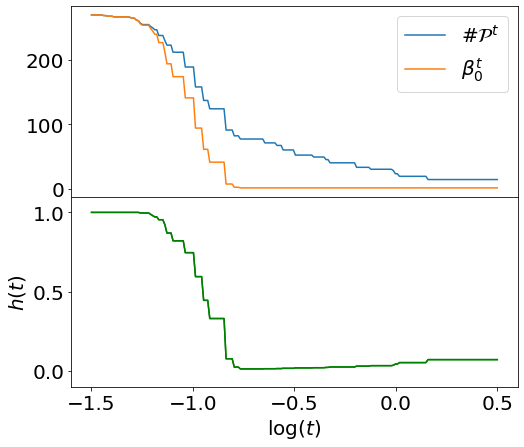

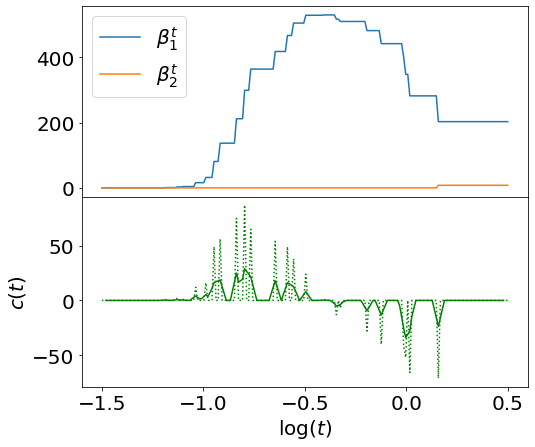

In [26]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.plot(log_scales,s_partitions, label = r'$\#\mathcal{P}^t$')
ax1.plot(log_scales,betti_numbers[:,0], label = r'$\beta_0^t$')
ax1.set(xticks=[])

ax1.legend()

ax2.plot(log_scales,compute_persistent_hierarchy(mcf), label = r'$h(t)$',c='green')
ax2.plot(log_scales,h, label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$\log(t)$',ylim=(-0.1,1.1))
plt.savefig(root_fig +'ER_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

import pandas as pd

def moving_average(x, w):
    return np.roll(
        np.asarray(pd.Series(x).rolling(window=w, win_type="triang").mean()),
        -int(w / 2),
    )

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,betti_1, label = r'$\beta_1^t$')
ax1.plot(log_scales,betti_2, label = r'$\beta_2^t$')

ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,c,c='green',ls=":")
ax2.plot(log_scales,moving_average(c,5),c='green')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
plt.savefig(root_fig +'ER_conflict.pdf', dpi=fig.dpi,bbox_inches='tight')

In [ ]:
~